Features to include in visualization:

* Predict production by county and overall state (top level prediction)
* Can zoom into active sites (this may get laggy depending on how we handle data)
* Timelapse of when wells were developed. Have a slider that shows welsl for a selected year
    * Selection of top producing wells to show spatial evolution?
*  

In [1]:
from sqlalchemy import create_engine, MetaData
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [2]:
engine = create_engine("sqlite:///../../kansas_oil_gas.db")
# Reflect oil production table
meta = MetaData()
meta.reflect(bind=engine)
oil_prod = meta.tables[OIL_PROD_TABLE]
gas_prod = meta.tables[GAS_PROD_TABLE]
lease = meta.tables[LEASE_TABLE]
wells = meta.tables[WELLS_TABLE]
tops = meta.tables[TOPS_TABLE]



In [3]:
s = select(
    [
        oil_prod.c.DATE,
        func.sum(oil_prod.c.WELLS).label("N_WELLS"),
        func.sum(oil_prod.c.PRODUCTION).label("MONTHLY_OIL_PROD"),
    ]
).group_by(oil_prod.c.DATE)
df_oil_prod = pd.read_sql(s, engine)

Check the relationship between number of wells to oil production. We should see a positive correlation with numbers of wells to production. 

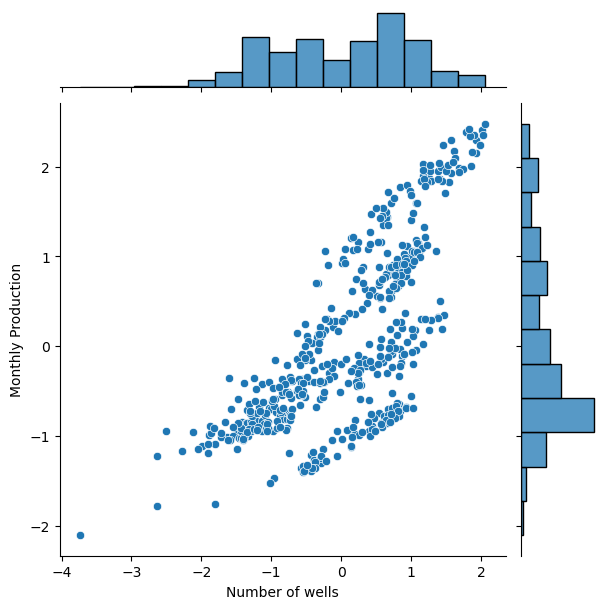

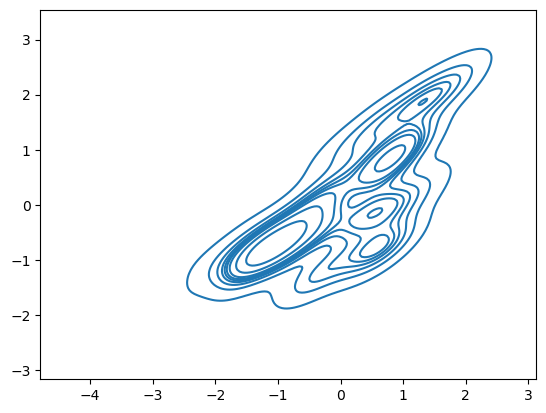

In [4]:
scale = StandardScaler()
nwells_scaled = scale.fit_transform(np.asarray(df_oil_prod["N_WELLS"])[:,None]).ravel()
oil_prod_scaled = scale.fit_transform(np.asarray(df_oil_prod["MONTHLY_OIL_PROD"])[:,None]).ravel()
sns.jointplot(x=nwells_scaled,y=oil_prod_scaled)
plt.xlabel("Number of wells")
plt.ylabel("Monthly Production")
plt.show()

sns.kdeplot(x=nwells_scaled,y=oil_prod_scaled)
plt.show()

There seems to be some clustering within the data as different sections of data seems to have a different relationship. Since these are time series, they might be seasonal effects, or technology effects (better technology throughout the years lead to increase in production from the same amount of wells), or even decom of new wells along with new wells giving the impression of increased production for the same number of wells.

Need to investigate how production varies in each lease? Maybe how lease start/end affects clustering? Geographic location?

In [5]:
kansas_prod = gpd.read_file("Shapefiles/OILGAS_FIELDS_GEO.shp")
kansas_poly = gpd.read_file("Shapefiles/kansas_poly.geojson")
#kansas_state = gpd.read_file("Shapefiles/tl_2017_20_cousub.shp")
kansas_state = gpd.read_file("Shapefiles/cb_2018_us_county_500k.shp")
kansas_state = kansas_state[kansas_state["STATEFP"]=='20'].reset_index(drop=True)

In [6]:
s = select(
    [
        lease.c.COUNTY,
        lease.c.PRODUCES,
        lease.c.PRODUCTION,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_lease = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_lease['LONGITUDE'],df_lease['LATITUDE'])]
df_lease = gpd.GeoDataFrame(df_lease, geometry=geometry, crs = kansas_state.crs)

# Get production average per year for each lease to see which counties have the most prolific production
df_lease['year_span'] = (df_lease['YEAR_STOP'] - df_lease['YEAR_START']).apply(lambda x: max(x,1))
df_lease["yearly_production"] = df_lease['PRODUCTION'] / df_lease['year_span']

In [65]:
df_lease_gas = df_lease[df_lease['PRODUCES'] == 'GAS'].reset_index(drop=True)
df_lease_oil = df_lease[df_lease['PRODUCES'] == 'OIL'].reset_index(drop=True)

# Rank leases
tot_ranks = 100
df_lease_gas['rank'] = pd.Categorical(np.ceil(df_lease_gas['yearly_production'].rank(pct=True).mul(tot_ranks)).astype('Int64'))
df_lease_oil['rank'] = pd.Categorical(np.ceil(df_lease_oil['yearly_production'].rank(pct=True).mul(tot_ranks)).astype('Int64'))


Text(0.5, 1.0, 'Oil Production')

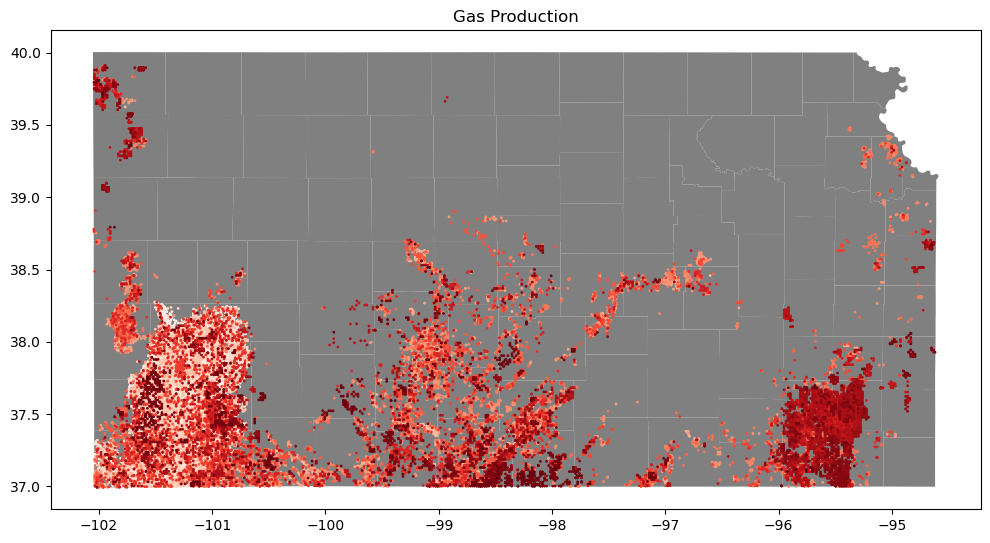

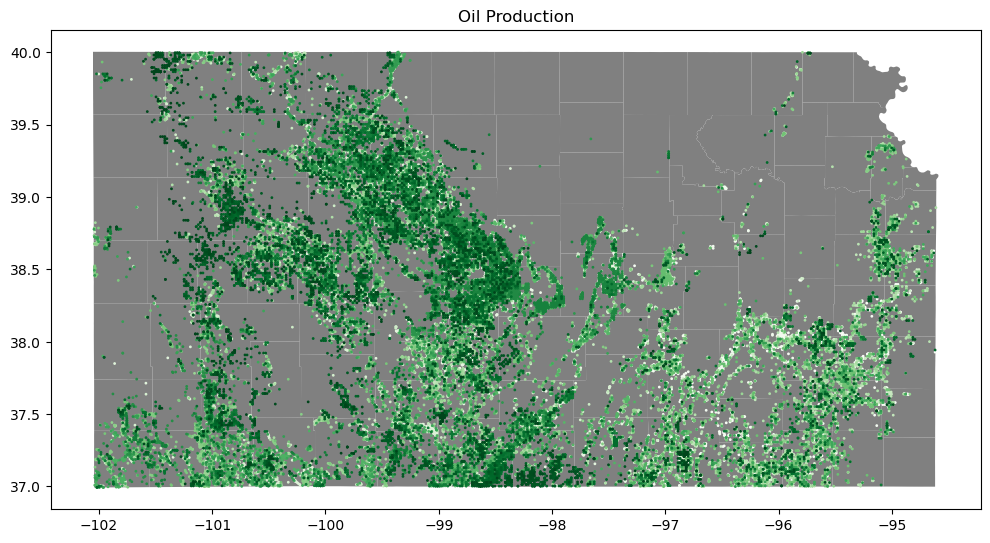

In [36]:
# Plot only Gas
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_lease_gas.plot(ax = ax, cmap = 'Reds', markersize = 1)
ax.set_title("Gas Production")

# Plot only Oil
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_lease_oil.plot(ax = ax, cmap = 'Greens', markersize = 1)
ax.set_title("Oil Production")


Determine Lease total production vs. Time series summation of production

In [148]:
s = select(
    [
        lease.c.LEASE_KID,
        lease.c.PRODUCES,
        lease.c.PRODUCTION
    ]
).where(lease.c.PRODUCTION != None)
df_total_production = pd.read_sql(s, engine)

s = select(
    [
        gas_prod.c.LEASE_KID,
        func.sum(gas_prod.c.PRODUCTION)
    ]
).group_by(gas_prod.c.LEASE_KID)
df_summed_gas_production = pd.read_sql(s, engine)

s = select(
    [
        oil_prod.c.LEASE_KID,
        func.sum(oil_prod.c.PRODUCTION)
    ]
).group_by(oil_prod.c.LEASE_KID)
df_summed_oil_production = pd.read_sql(s, engine)

# Merge into one df
df_total_production = df_total_production.merge(df_summed_gas_production, on="LEASE_KID", how="left") \
                            .rename(columns={"sum_1":"summed_gas"}).fillna(0)
df_total_production = df_total_production.merge(df_summed_oil_production, on="LEASE_KID", how="left") \
                            .rename(columns={"sum_1":"summed_oil"}).fillna(0)

df_total_production["Summations"] = df_total_production["summed_gas"] + df_total_production["summed_oil"]
df_total_production = df_total_production.drop(["summed_gas","summed_oil"], axis=1)


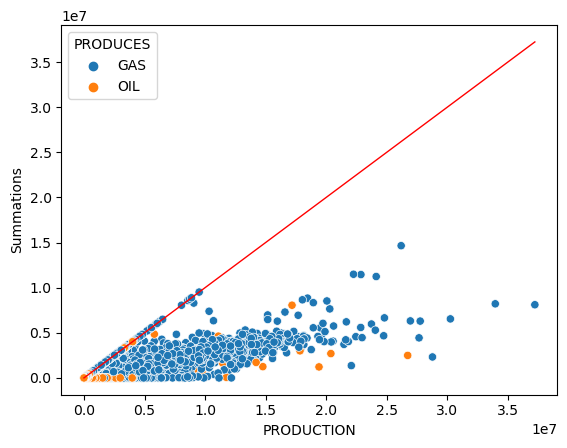

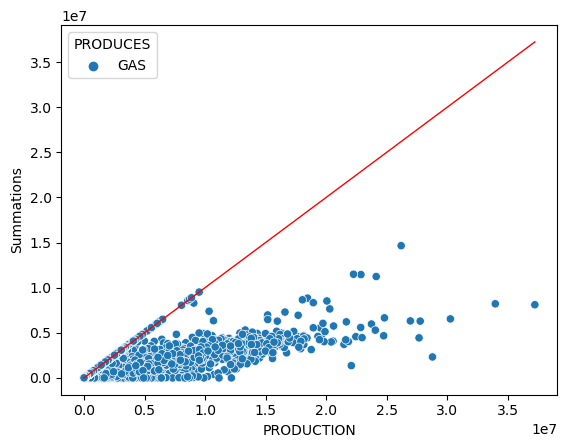

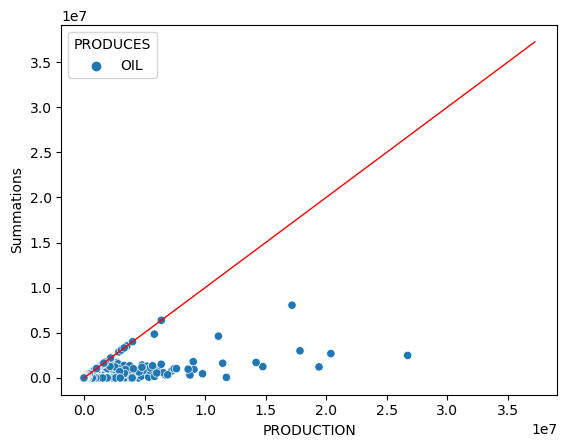

In [174]:
max_prod = max(df_total_production["PRODUCTION"].max(),df_total_production["Summations"].max())
sns.scatterplot(data=df_total_production, x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

sns.scatterplot(data=df_total_production[df_total_production["PRODUCES"]=="GAS"], x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

sns.scatterplot(data=df_total_production[df_total_production["PRODUCES"]=="OIL"], x='PRODUCTION', y='Summations', hue="PRODUCES")
X_plot = np.linspace(0, max_prod, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot,linewidth=1, color='red')
plt.show()

Detemine how many leases are active and how many are abandoned

In [192]:
s = select(
    [
        lease.c.LEASE_KID,
        lease.c.YEAR_START,
        lease.c.YEAR_STOP,
        lease.c.LATITUDE,
        lease.c.LONGITUDE
    ]
).where(lease.c.PRODUCTION != None)
df_active_leases = pd.read_sql(s, engine)
geometry = [Point(xy) for xy in zip(df_active_leases['LONGITUDE'],df_active_leases['LATITUDE'])]
df_active_leases = gpd.GeoDataFrame(df_active_leases, geometry=geometry, crs = kansas_state.crs)

df_active_leases["active"] = df_active_leases['YEAR_STOP'] == 2022
df_active_leases["years_active"] = (df_active_leases["YEAR_STOP"] - df_active_leases["YEAR_START"]).apply(lambda x: max(1,x))


In [198]:
print(df_active_leases["LEASE_KID"].count())
print(df_active_leases[df_active_leases["active"]==True]["LEASE_KID"].count())
print(df_active_leases[df_active_leases["active"]==False]["LEASE_KID"].count())

95329
31748
63581


Text(0.5, 1.0, 'Inactive Production')

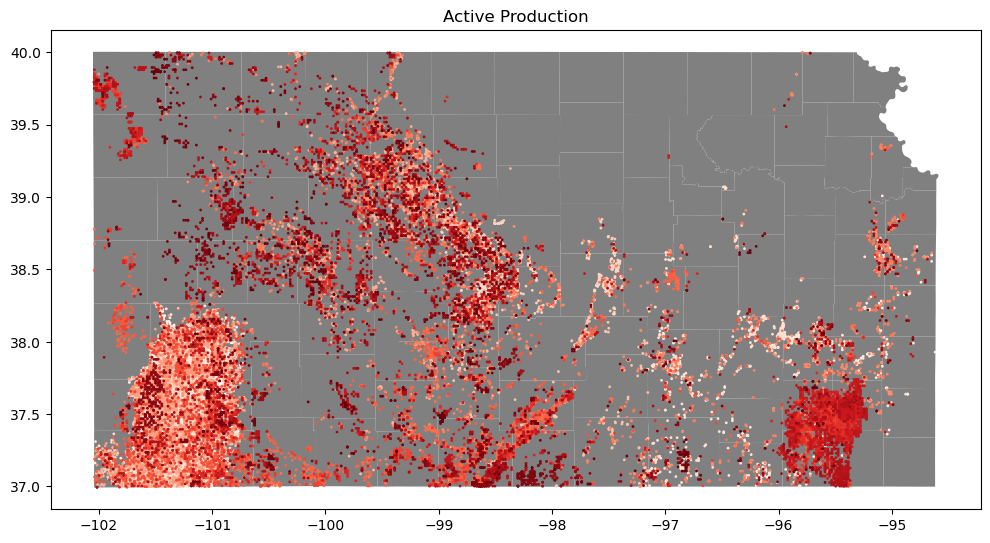

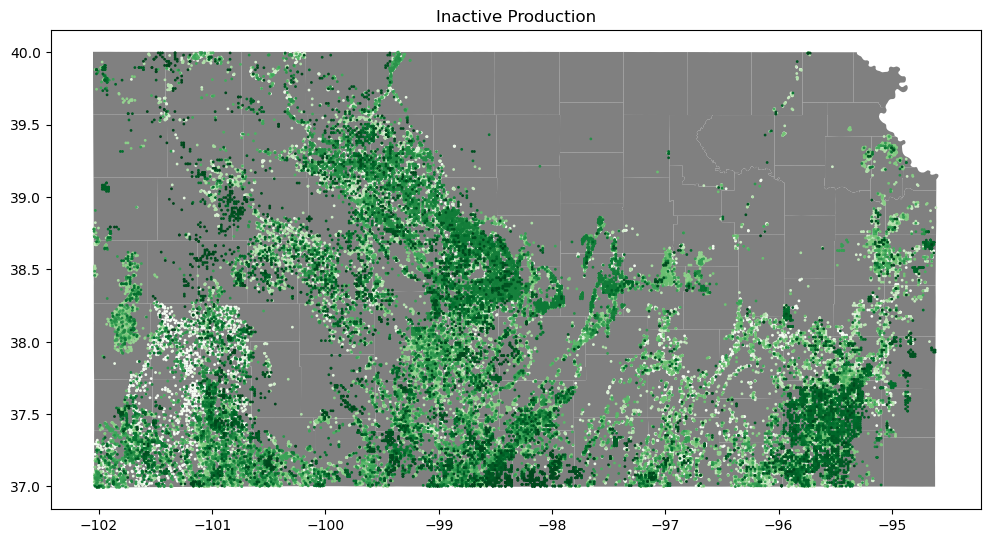

In [199]:
# Plot active leases
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_active_leases[df_active_leases["active"]==True].plot(ax = ax, cmap = 'Reds', markersize = 1)
ax.set_title("Active Production")

# Plot inactive leases
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey')
df_active_leases[df_active_leases["active"]==False].plot(ax = ax, cmap = 'Greens', markersize = 1)
ax.set_title("Inactive Production")


See which counties have the highest producing leases

In [67]:
kansas_counties = kansas_state[["NAME",'geometry']]

# Oil
top_oil_leases = df_lease_oil[df_lease_oil['rank'] == tot_ranks].reset_index(drop=True)
top_oil_leases = gpd.sjoin(top_oil_leases, kansas_counties, how="inner", predicate="intersects")

# Gas
top_gas_leases = df_lease_gas[df_lease_gas['rank'] == tot_ranks].reset_index(drop=True)
top_gas_leases = gpd.sjoin(top_gas_leases, kansas_counties, how="inner", predicate="intersects")

Top 1% of wells

Text(0.5, 1.0, 'Oil Production')

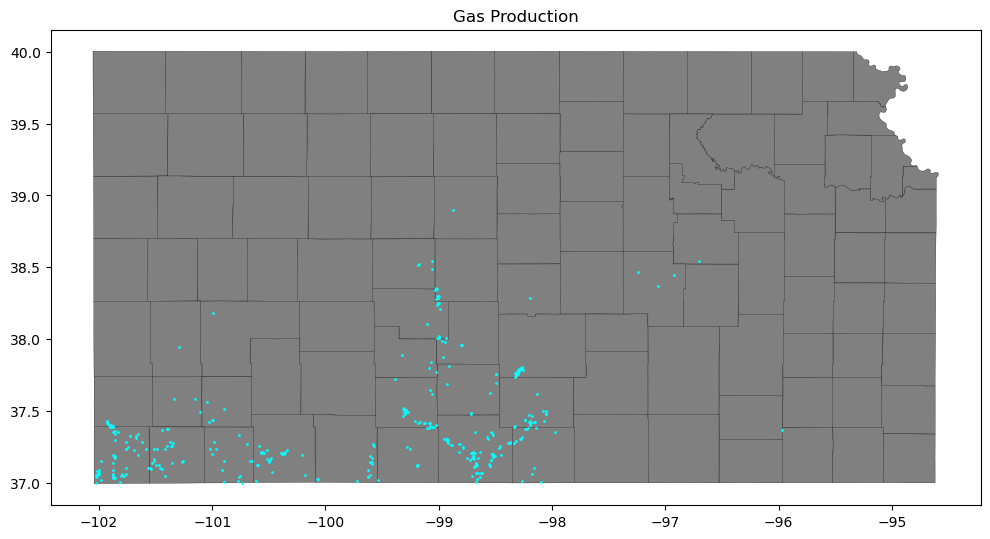

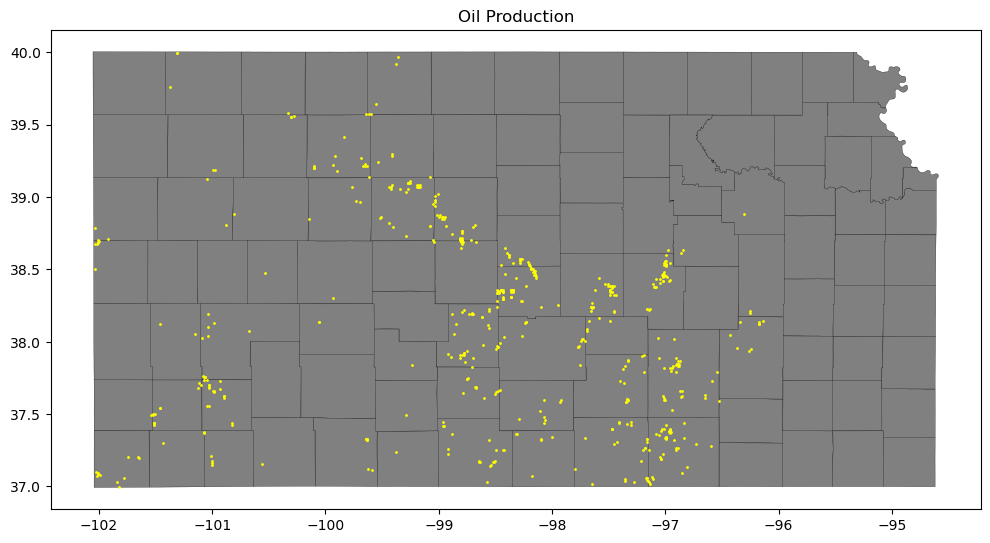

In [78]:
# Plot only Gas
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
top_gas_leases.plot(ax = ax, color = 'cyan', markersize = 1)
ax.set_title("Gas Production")

# Plot only Oil
fig, ax = plt.subplots(figsize = (12,10))
kansas_state.plot(ax = ax, color = 'grey', edgecolor='black', linewidth=0.2)
top_oil_leases.plot(ax = ax, color = 'yellow', markersize = 1)
ax.set_title("Oil Production")

In [69]:
print(pd.unique(kansas_state['NAME']).size)
print(pd.unique(top_oil_leases['NAME']).size)
print(pd.unique(top_gas_leases['NAME']).size)


105
53
27


Get active wells (end date is 2022 in db)